# Regresión logística regularizada

La regularización es una técnica utilizada para evitar el problema de sobreajuste (overfitting) en modelos estadísticos.
A medida que vamos agregando nuevos atributos a nuestro modelo, el mismo se va tornando más interesante pero también mucho más complejo (agregamos términos polinómicos, etc). El mismo quizás tenga un buen desempeño haciendo predicciones sobre el conjunto de entrenamiento pero tiene un bajo desempeño predictivo generalizando nuevos ejemplos.

En este ejericicio utilizaremos la regresión logística regularizada para saber si los microchips de una planta de fabricacion pasan el test de calidad. Durante los tests de calidad los microchips pasan por varias pruebas para asegurar su correcto funcionamiento.

Supongamos que eres el gerente del producto de la fábrica y tienes los resultados de algunos microchips para dos tipos de pruebas. A partir de estas dos pruebas quieres determinar si los microchips deberían ser aceptados o rechazados.
Para ello se tienen datos históricos de resultados de pruebas anteriores, desde el cual vamos a construir el modelo logistico.

#### Configuración de tamaño de gráficos

In [18]:
options(repr.plot.width=5, repr.plot.height=4, scipen = 999)

#### Instalación y carga de paquetes necesarios

In [19]:
list.of.packages <- c('ggplot2')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(ggplot2)

#### Carga de datos

In [20]:
microchips <- read.table(file = 'ex2data2.txt', header = TRUE, 
                        col.names = c('test1', 'test2', 'accepted'), sep = ",", dec = ".")

## Exploración de datos

In [21]:
head(microchips)
microchips$accepted <- factor(microchips$accepted, levels = c(1, 0), labels = c('Aceptado', 'Rechazado'))
str(microchips)

test1,test2,accepted
-0.092742,0.684940,1
-0.213710,0.692250,1
-0.375000,0.502190,1
-0.513250,0.465640,1
-0.524770,0.209800,1
-0.398040,0.034357,1


'data.frame':	117 obs. of  3 variables:
 $ test1   : num  -0.0927 -0.2137 -0.375 -0.5132 -0.5248 ...
 $ test2   : num  0.685 0.692 0.502 0.466 0.21 ...
 $ accepted: Factor w/ 2 levels "Aceptado","Rechazado": 1 1 1 1 1 1 1 1 1 1 ...


## Visualización de datos

### Gráfico de dispersión

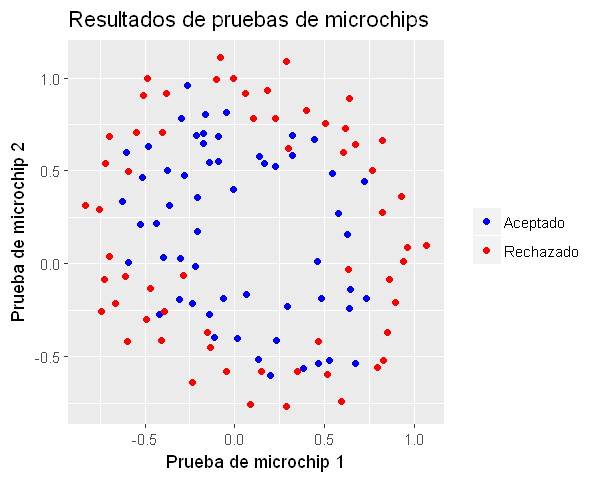

In [22]:
ggplot(data = microchips, aes(x = test1, y = test2, col = accepted)) + geom_point() +
    labs(x = 'Prueba de microchip 1', y = 'Prueba de microchip 2') + ggtitle('Resultados de pruebas de microchips') +
    theme(legend.title=element_blank()) +
    scale_colour_manual(name='', values=c('Aceptado'='blue', 'Rechazado'='red'))

A simple viste vemos que ambas clases no pueden ser separados a través de una linea recta, por lo tanto utilizar una enfoque directo de la regresión lineal no sería conveniente. 

Por lo tanto tendremos que construir más atributos de entrada a partir de los dos que tenemos. Para ello usaremos términos polinómicos hasta el grado 6.

Es decir, no solo tendremos x0, x1 y x2, sino que deberíamos tener: x0, x1, x2, x1*x2, x1*x2^2, x1^2*x2... x1^6 * x2^6.

Una regresión logística con estas entradas tendrá una frontera entre clases mucho más compleja y se ajustará mucho mejor a los datos pero por otro lado es más susceptible a sobreajustarse, por lo tanto debemos **REGULARIZAR**.

#### Preparamos los datos para la regresión

In [23]:
X <- microchips$test1
X <- cbind(X, microchips$test2)

y <- 2 - as.integer(microchips$accepted)

m <- nrow(X)
degree <- 6
lambda <- 1

#### Chequeamos las primeras 10 observaciones

In [24]:
head(X,10)
head(y,10)

X,
-0.092742,0.684940
-0.213710,0.692250
-0.375000,0.502190
-0.513250,0.465640
-0.524770,0.209800
-0.398040,0.034357
-0.305880,-0.192250
0.016705,-0.404240
0.131910,-0.513890
0.385370,-0.565060


[1] 1 1 1 1 1 1 1 1 1 1

#### Creamos los nuevos términos polinómicos

In [25]:
agregarAtributos <- function(X1, X2) {
    
    out <- matrix(1,length(X1),1)
  
    for (i in 1:degree)
       for (j in 0:i)
         out <- cbind(out, (X1 ^ (i - j)) * (X2 ^ j))

    out
}
        
X <- agregarAtributos(X[,1], X[,2])

#### Creamos la función sigmoidal.

In [26]:
sigmoid <- function(z) {
  
  g <- 1 / (1 + exp(1) ^ (-z))
}

#### Construimos la función para calcular el costo y los gradientes.

In [27]:
computeCost <- function(theta) {
    
    hyp <-  sigmoid(X %*% theta)
    
    J_noreg <- (-1 / m) * (t(y) %*% log(hyp) + (t((1 - y)) %*% log(1 - hyp)))
        
    theta[1] <- 0
    
    J_reg <- J_noreg + (lambda / (2 * m)) * sum(theta ^ 2)
    
    J_reg
    
}

computeGrad <- function(theta) {
    
    hyp <- sigmoid(X %*% theta)
    
    theta1 <- c(0,theta[-1])
    
    grad <- (t(X) %*% (hyp - y) + lambda * theta1) / m
    grad
}

#### Inicializamos los parámetros theta

In [28]:
initial_theta <- numeric(ncol(X))

#### Configuramos las opciones de optim
optim() es una librería en R para optimizar funciones (minimizar/maximizar)

In [29]:
results_optim <- optim(par = initial_theta, fn = computeCost, gr = computeGrad, method="BFGS", control = list(maxit = 400))

theta <- results_optim$par
J <- results_optim$value

In [36]:
cat('Costo final:', J)
cat('\n\nValores óptimos de theta:\n', theta)

Costo final: 0.5304075

Valores óptimos de theta:
 1.257178 0.6184102 1.151225 -1.9899 -0.9210801 -1.447153 0.1268861 -0.3430642 -0.3608105 -0.1790847 -1.454376 -0.04757986 -0.6032457 -0.2769599 -1.18793 -0.2428991 -0.1992249 -0.04355907 -0.2679924 -0.2977525 -0.443909 -1.044985 0.02951311 -0.2896819 0.01685307 -0.3209932 -0.1456206 -0.9081981

## Visualización de límites entre cada clase

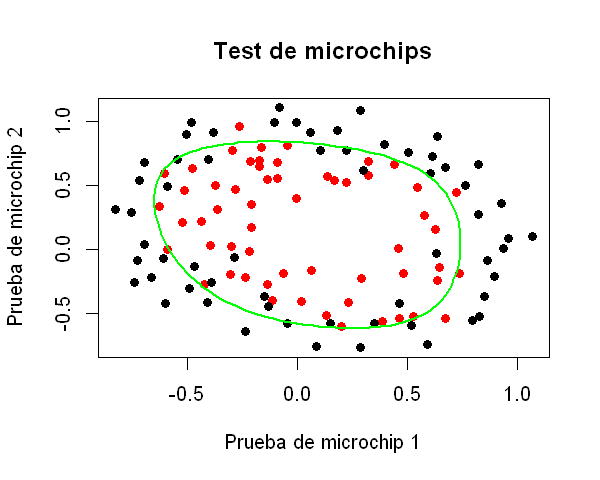

In [39]:
#Graficamos los puntos
plot(X[,2], X[,3], col = factor(y), pch = 19, xlab = "Prueba de microchip 1", ylab = "Prueba de microchip 2",
    main = "Test de microchips")

# Creamos la grilla para dibujar el limite entre las clases
u <- seq(-1,1.5, length.out = 50)
v <- seq(-1,1.5, length.out = 50)
z <- matrix(0, length(u), length(v))

# Evaluamos z sobre la grilla de puntos
for (i in 1:length(u))
    for (j in 1:length(v))
      z[i,j] <- agregarAtributos(u[i], v[j]) %*% theta

#Dibujamos el limite
contour(u, v, z, levels = 0, lwd = 2, add = TRUE, drawlabels = FALSE, col = "green")

## Precisión del modelo (%)


In [32]:
p <- round(sigmoid(X %*% theta))
round(mean(p == y) * 100, 2)

[1] 82.91